In [1]:
import os
import sys
import tqdm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import seed
from skopt import BayesSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error

sys.path.append('.')
sys.path.append('../../')
sys.path.append('../network_model/')
sys.path.append('../validation/')

notebook_path = os.getcwd()
project_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.append(project_path)

from network_model.network_classes import Network
from networks_container import NetworksContainer
from estimator import Estimator

In [2]:
cherrypicked_seed = 42

seed(cherrypicked_seed)
random.seed(cherrypicked_seed)

In [3]:
dataset_obama = pd.read_csv("../datasets/obamaAnonimized.csv", dtype=str)

In [4]:
endorsers_percentage_list = pd.read_csv("../datasets/obama_endorsers_hours_percentage_list.csv", dtype=int, header=None)
endorsers_percentage_list = endorsers_percentage_list.values.tolist()
endorsers_percentage_list = [item for sublist in endorsers_percentage_list for item in sublist]

In [5]:
print(len(endorsers_percentage_list))

4730


In [6]:
# Tolgo 1 in quanto considero la prima epoca come lo stato iniziale
epochs = len(endorsers_percentage_list) - 1

In [7]:
print(len(dataset_obama))

4337


In [8]:
n_nodes = 2678
n_nodes

2678

In [9]:
n_bots = round((1 / 100) * n_nodes)
n_bots

27

In [10]:
n_fact_checkers = round((1 / 100) * n_nodes)
n_fact_checkers

27

In [11]:
n_influencers = 29

In [12]:
n_commons = n_nodes - n_bots - n_fact_checkers - n_influencers
n_commons

2595

In [13]:
n_initial_infected_nodes = round((1 / 100) * n_nodes) - n_bots
n_initial_infected_nodes

0

In [14]:
# Prendo i parametri calibrati con un dataset diverso da quello usato per la validazione
parameters_df = pd.read_csv("../validation/parameters/parameters_optimization_palin_hours_homophily_0.50.csv")

In [15]:
parameters_df = parameters_df.sort_values(by='rmse')
parameters_df

,alpha,beta,homophily,prob_infection,prob_vaccination,prob_cure,prob_influencer,prob_echo,rmse
16,0.50,0.33,0.5,0.360038,0.056790,0.216255,0.098907,0.617839,1.405257
17,0.50,0.50,0.5,0.454669,0.098769,0.211907,0.101289,0.250256,2.821633
15,0.50,0.25,0.5,0.308446,0.007363,0.157705,0.510944,0.549876,2.909999
19,0.75,0.25,0.5,0.448473,0.139018,0.030732,0.006663,0.825364,3.469475
9,0.25,0.75,0.5,0.471125,0.095869,0.172569,0.407868,0.015595,3.713381
12,0.33,0.33,0.5,0.317698,0.007074,0.214766,0.499534,0.120162,9.119578
13,0.33,0.50,0.5,0.439607,0.077711,0.071581,0.018257,0.299499,11.036833
8,0.25,0.50,0.5,0.481207,0.075433,0.153820,0.221028,0.824805,11.741975
6,0.25,0.25,0.5,0.418224,0.000221,0.119561,0.112658,0.001969,15.698193
4,0.00,0.75,0.5,0.437207,0.035077,0.234331,0.816667,0.986421,16.186571


In [16]:
alpha = parameters_df['alpha'].iloc[0]
beta = parameters_df['beta'].iloc[0]
homophily = parameters_df['homophily'].iloc[0]
prob_infection = parameters_df['prob_infection'].iloc[0]
prob_vaccination = parameters_df['prob_vaccination'].iloc[0]
prob_cure = parameters_df['prob_cure'].iloc[0]
prob_influencer = parameters_df['prob_influencer'].iloc[0]
prob_echo = 0.0

In [17]:
container = NetworksContainer(n_networks=30, n_nodes=n_nodes, 
                              alpha=alpha, beta=beta, 
                              delta_in=1, delta_out=1, 
                              homophily=homophily, n_commons=n_commons, 
                              n_influencers=n_influencers, n_bots=n_bots, 
                              n_fact_checkers=n_fact_checkers,
                              prob_complaint=0.0, 
                              prob_infection=prob_infection, 
                              prob_vaccination=prob_vaccination,
                              prob_cure=prob_cure, 
                              prob_influencer=prob_influencer, 
                              exp_decay=True, user_block=False, 
                              prob_echo=prob_echo, epochs=epochs)
container.create_network_list(n_initial_infected_nodes=n_initial_infected_nodes)

In [18]:
total_y_pred_list_prob_000 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_000.append(y_pred_list)

In [19]:
prob_echo = 0.25
container.set_prob_echo(prob_echo)

In [20]:
total_y_pred_list_prob_025 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_025.append(y_pred_list)

In [21]:
prob_echo = 0.50
container.set_prob_echo(prob_echo)

In [22]:
total_y_pred_list_prob_050 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_050.append(y_pred_list)

In [23]:
prob_echo = 0.75
container.set_prob_echo(prob_echo)

In [24]:
total_y_pred_list_prob_075 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_075.append(y_pred_list)

In [25]:
prob_echo = 1.00
container.set_prob_echo(prob_echo)

In [26]:
total_y_pred_list_prob_100 = []

for i in range(container.n_networks):   
    y_pred_list = []
    container.network_list[i].reset_network()
    for j in range(container.epochs):
        container.network_list[i].update_nodes()
    y_pred_list = container.network_list[i].perc_infected
    total_y_pred_list_prob_100.append(y_pred_list)

In [27]:
avg_y_pred_list_prob_000 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_000)]
avg_y_pred_list_prob_025 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_025)]
avg_y_pred_list_prob_050 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_050)]
avg_y_pred_list_prob_075 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_075)]
avg_y_pred_list_prob_100 = [sum(column) / len(column) for column in zip(*total_y_pred_list_prob_100)]

In [28]:
std_y_pred_list_prob_000 = [np.std(column) for column in zip(*total_y_pred_list_prob_000)]
std_y_pred_list_prob_025 = [np.std(column) for column in zip(*total_y_pred_list_prob_025)]
std_y_pred_list_prob_050 = [np.std(column) for column in zip(*total_y_pred_list_prob_050)]
std_y_pred_list_prob_075 = [np.std(column) for column in zip(*total_y_pred_list_prob_075)]
std_y_pred_list_prob_100 = [np.std(column) for column in zip(*total_y_pred_list_prob_100)]

In [29]:
std_low_y_pred_list_prob_000 = []
std_high_y_pred_list_prob_000 = []
std_low_y_pred_list_prob_025 = []
std_high_y_pred_list_prob_025 = []
std_low_y_pred_list_prob_050 = []
std_high_y_pred_list_prob_050 = []
std_low_y_pred_list_prob_075 = []
std_high_y_pred_list_prob_075 = []
std_low_y_pred_list_prob_100 = []
std_high_y_pred_list_prob_100 = []

for i in range(len(avg_y_pred_list_prob_000)):
    std_low_y_pred_list_prob_000.append(avg_y_pred_list_prob_000[i] - std_y_pred_list_prob_000[i])
    std_high_y_pred_list_prob_000.append(avg_y_pred_list_prob_000[i] + std_y_pred_list_prob_000[i])

for i in range(len(avg_y_pred_list_prob_025)):
    std_low_y_pred_list_prob_025.append(avg_y_pred_list_prob_025[i] - std_y_pred_list_prob_025[i])
    std_high_y_pred_list_prob_025.append(avg_y_pred_list_prob_025[i] + std_y_pred_list_prob_025[i])

for i in range(len(avg_y_pred_list_prob_050)):
    std_low_y_pred_list_prob_050.append(avg_y_pred_list_prob_050[i] - std_y_pred_list_prob_050[i])
    std_high_y_pred_list_prob_050.append(avg_y_pred_list_prob_050[i] + std_y_pred_list_prob_050[i])

for i in range(len(avg_y_pred_list_prob_075)):
    std_low_y_pred_list_prob_075.append(avg_y_pred_list_prob_075[i] - std_y_pred_list_prob_075[i])
    std_high_y_pred_list_prob_075.append(avg_y_pred_list_prob_075[i] + std_y_pred_list_prob_075[i])

for i in range(len(avg_y_pred_list_prob_100)):
    std_low_y_pred_list_prob_100.append(avg_y_pred_list_prob_100[i] - std_y_pred_list_prob_100[i])
    std_high_y_pred_list_prob_100.append(avg_y_pred_list_prob_100[i] + std_y_pred_list_prob_100[i])

In [30]:
x = []
for i in range(len(endorsers_percentage_list)):
    x.append(i)

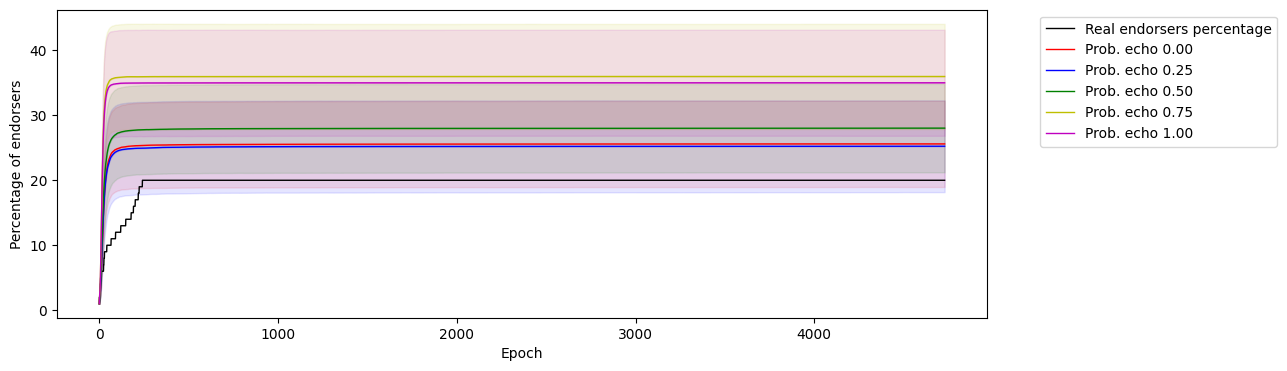

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list, c='k', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_prob_000, c='r', label='Prob. echo 0.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_000, std_low_y_pred_list_prob_000, color='r', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_000, std_high_y_pred_list_prob_000, color='r', alpha=.1)
plt.plot(avg_y_pred_list_prob_025, c='b', label='Prob. echo 0.25', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_025, std_low_y_pred_list_prob_025, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_025, std_high_y_pred_list_prob_025, color='b', alpha=.1)
plt.plot(avg_y_pred_list_prob_050, c='g', label='Prob. echo 0.50', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_050, std_low_y_pred_list_prob_050, color='g', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_050, std_high_y_pred_list_prob_050, color='g', alpha=.1)
plt.plot(avg_y_pred_list_prob_075, c='y', label='Prob. echo 0.75', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_075, std_low_y_pred_list_prob_075, color='y', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_075, std_high_y_pred_list_prob_075, color='y', alpha=.1)
plt.plot(avg_y_pred_list_prob_100, c='m', label='Prob. echo 1.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_100, std_low_y_pred_list_prob_100, color='m', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_100, std_high_y_pred_list_prob_100, color='m', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [32]:
x = []
endorsers_percentage_list_truncated = []
avg_y_pred_list_prob_000_truncated = []
std_low_y_pred_list_prob_000_truncated = []
std_high_y_pred_list_prob_000_truncated = []
avg_y_pred_list_prob_025_truncated = []
std_low_y_pred_list_prob_025_truncated = []
std_high_y_pred_list_prob_025_truncated = []
avg_y_pred_list_prob_050_truncated = []
std_low_y_pred_list_prob_050_truncated = []
std_high_y_pred_list_prob_050_truncated = []
avg_y_pred_list_prob_075_truncated = []
std_low_y_pred_list_prob_075_truncated = []
std_high_y_pred_list_prob_075_truncated = []
avg_y_pred_list_prob_100_truncated = []
std_low_y_pred_list_prob_100_truncated = []
std_high_y_pred_list_prob_100_truncated = []
for i in range(500):
    x.append(i)
    endorsers_percentage_list_truncated.append(endorsers_percentage_list[i])
    avg_y_pred_list_prob_000_truncated.append(avg_y_pred_list_prob_000[i])
    std_low_y_pred_list_prob_000_truncated.append(std_low_y_pred_list_prob_000[i])
    std_high_y_pred_list_prob_000_truncated.append(std_high_y_pred_list_prob_000[i])
    avg_y_pred_list_prob_025_truncated.append(avg_y_pred_list_prob_025[i])
    std_low_y_pred_list_prob_025_truncated.append(std_low_y_pred_list_prob_025[i])
    std_high_y_pred_list_prob_025_truncated.append(std_high_y_pred_list_prob_025[i])
    avg_y_pred_list_prob_050_truncated.append(avg_y_pred_list_prob_050[i])
    std_low_y_pred_list_prob_050_truncated.append(std_low_y_pred_list_prob_050[i])
    std_high_y_pred_list_prob_050_truncated.append(std_high_y_pred_list_prob_050[i])
    avg_y_pred_list_prob_075_truncated.append(avg_y_pred_list_prob_075[i])
    std_low_y_pred_list_prob_075_truncated.append(std_low_y_pred_list_prob_075[i])
    std_high_y_pred_list_prob_075_truncated.append(std_high_y_pred_list_prob_075[i])
    avg_y_pred_list_prob_100_truncated.append(avg_y_pred_list_prob_100[i])
    std_low_y_pred_list_prob_100_truncated.append(std_low_y_pred_list_prob_100[i])
    std_high_y_pred_list_prob_100_truncated.append(std_high_y_pred_list_prob_100[i])

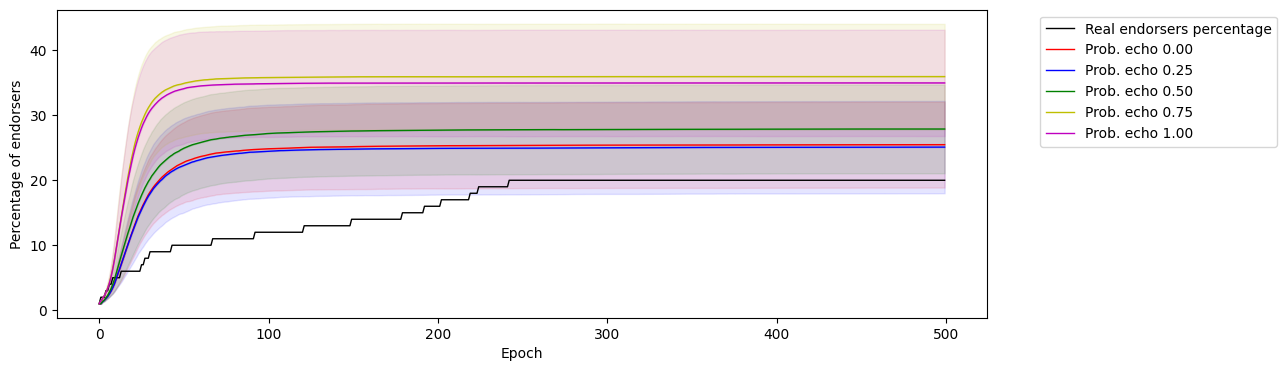

In [33]:
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
axs.plot(endorsers_percentage_list_truncated, c='k', label='Real endorsers percentage', linewidth=1.0)
plt.plot(avg_y_pred_list_prob_000_truncated, c='r', label='Prob. echo 0.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_000_truncated, std_low_y_pred_list_prob_000_truncated, color='r', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_000_truncated, std_high_y_pred_list_prob_000_truncated, color='r', alpha=.1)
plt.plot(avg_y_pred_list_prob_025_truncated, c='b', label='Prob. echo 0.25', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_025_truncated, std_low_y_pred_list_prob_025_truncated, color='b', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_025_truncated, std_high_y_pred_list_prob_025_truncated, color='b', alpha=.1)
plt.plot(avg_y_pred_list_prob_050_truncated, c='g', label='Prob. echo 0.50', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_050_truncated, std_low_y_pred_list_prob_050_truncated, color='g', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_050_truncated, std_high_y_pred_list_prob_050_truncated, color='g', alpha=.1)
plt.plot(avg_y_pred_list_prob_075_truncated, c='y', label='Prob. echo 0.75', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_075_truncated, std_low_y_pred_list_prob_075_truncated, color='y', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_075_truncated, std_high_y_pred_list_prob_075_truncated, color='y', alpha=.1)
plt.plot(avg_y_pred_list_prob_100_truncated, c='m', label='Prob. echo 1.00', linewidth=1.0)
axs.fill_between(x, avg_y_pred_list_prob_100_truncated, std_low_y_pred_list_prob_100_truncated, color='m', alpha=.1)
axs.fill_between(x, avg_y_pred_list_prob_100_truncated, std_high_y_pred_list_prob_100_truncated, color='m', alpha=.1)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Epoch")
plt.ylabel("Percentage of endorsers")
plt.show()

In [34]:
y_true = endorsers_percentage_list

neg_rmse_list_prob_000 = []
neg_rmse_list_prob_025 = []
neg_rmse_list_prob_050 = []
neg_rmse_list_prob_075 = []
neg_rmse_list_prob_100 = []

for i in range(container.n_networks):
        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_000[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_000.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_025[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_025.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_050[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_050.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_075[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_075.append(neg_rmse)

        mse = mean_squared_error(y_true=y_true, y_pred=total_y_pred_list_prob_100[i])
        neg_rmse = - np.sqrt(mse)
        neg_rmse_list_prob_100.append(neg_rmse)
    
mean_neg_rmse_prob_000 = np.mean(neg_rmse_list_prob_000)
std_neg_rmse_prob_000 = np.std(neg_rmse_list_prob_000)
mean_neg_rmse_prob_025 = np.mean(neg_rmse_list_prob_025)
std_neg_rmse_prob_025 = np.std(neg_rmse_list_prob_025)
mean_neg_rmse_prob_050 = np.mean(neg_rmse_list_prob_050)
std_neg_rmse_prob_050 = np.std(neg_rmse_list_prob_050)
mean_neg_rmse_prob_075 = np.mean(neg_rmse_list_prob_075)
std_neg_rmse_prob_075 = np.std(neg_rmse_list_prob_075)
mean_neg_rmse_prob_100 = np.mean(neg_rmse_list_prob_100)
std_neg_rmse_prob_100 = np.std(neg_rmse_list_prob_100)

In [35]:
print("Mean 0.00: ", mean_neg_rmse_prob_000)
print("Standard deviation 0.00: ", std_neg_rmse_prob_000)

Mean 0.00:  -7.7382378273797086
Standard deviation 0.00:  4.365324732089308


In [36]:
print("Mean 0.25: ", mean_neg_rmse_prob_025)
print("Standard deviation 0.25: ", std_neg_rmse_prob_025)

Mean 0.25:  -8.054984309949312
Standard deviation 0.25:  4.024290092161188


In [37]:
print("Mean 0.50: ", mean_neg_rmse_prob_050)
print("Standard deviation 0.50: ", std_neg_rmse_prob_050)

Mean 0.50:  -9.59720204387064
Standard deviation 0.50:  4.813921347775155


In [38]:
print("Mean 0.75: ", mean_neg_rmse_prob_075)
print("Standard deviation 0.75: ", std_neg_rmse_prob_075)

Mean 0.75:  -17.198273796736334
Standard deviation 0.75:  5.936362117000631


In [39]:
print("Mean 1.00: ", mean_neg_rmse_prob_100)
print("Standard deviation 1.00: ", std_neg_rmse_prob_100)

Mean 1.00:  -15.820532834894253
Standard deviation 1.00:  7.1690808939507304


In [40]:
df_total_y_pred_list_000 = pd.DataFrame(total_y_pred_list_prob_000).T
df_total_y_pred_list_000.to_csv("sensitivity_echo_0.00_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_025 = pd.DataFrame(total_y_pred_list_prob_025).T
df_total_y_pred_list_025.to_csv("sensitivity_echo_0.25_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_050 = pd.DataFrame(total_y_pred_list_prob_050).T
df_total_y_pred_list_050.to_csv("sensitivity_echo_0.50_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_075 = pd.DataFrame(total_y_pred_list_prob_075).T
df_total_y_pred_list_075.to_csv("sensitivity_echo_0.75_obama_endorsers_percentages.csv", index=False, header=False)

df_total_y_pred_list_100 = pd.DataFrame(total_y_pred_list_prob_100).T
df_total_y_pred_list_100.to_csv("sensitivity_echo_1.00_obama_endorsers_percentages.csv", index=False, header=False)

In [41]:
df_statistics = pd.DataFrame(avg_y_pred_list_prob_000).T
df_statistics.loc[1] = std_y_pred_list_prob_000
df_statistics.loc[2] = std_high_y_pred_list_prob_000
df_statistics.loc[3] = std_low_y_pred_list_prob_000
df_statistics.loc[4] = avg_y_pred_list_prob_025
df_statistics.loc[5] = std_y_pred_list_prob_025
df_statistics.loc[6] = std_high_y_pred_list_prob_025
df_statistics.loc[7] = std_low_y_pred_list_prob_025
df_statistics.loc[8] = avg_y_pred_list_prob_050
df_statistics.loc[9] = std_y_pred_list_prob_050
df_statistics.loc[10] = std_high_y_pred_list_prob_050
df_statistics.loc[11] = std_low_y_pred_list_prob_050
df_statistics.loc[12] = avg_y_pred_list_prob_075
df_statistics.loc[13] = std_y_pred_list_prob_075
df_statistics.loc[14] = std_high_y_pred_list_prob_075
df_statistics.loc[15] = std_low_y_pred_list_prob_075
df_statistics.loc[16] = avg_y_pred_list_prob_100
df_statistics.loc[17] = std_y_pred_list_prob_100
df_statistics.loc[18] = std_high_y_pred_list_prob_100
df_statistics.loc[19] = std_low_y_pred_list_prob_100
df_statistics.to_csv("sensitivity_echo_obama_statistics.csv", index=False, header=False)

In [42]:
df_sensitivity_rmse = pd.DataFrame(neg_rmse_list_prob_000).T
df_sensitivity_rmse.loc[1] = neg_rmse_list_prob_025
df_sensitivity_rmse.loc[2] = neg_rmse_list_prob_050
df_sensitivity_rmse.loc[3] = neg_rmse_list_prob_075
df_sensitivity_rmse.loc[4] = neg_rmse_list_prob_100
df_sensitivity_rmse.to_csv("sensitivity_echo_obama_rmse.csv", index=False, header=False)